## Phase 3: Predicting Return Risk (Modeling)

**Objective:**  
Build a predictive model to identify orders with a high likelihood of being returned. This empowers **AfriMarket** to take **proactive actions** such as flagging risky transactions, optimizing logistics, and reducing avoidable costs.

**Why It Matters:**  
Returned orders increase logistics costs and impact customer satisfaction. Early detection allows the business to prevent losses, improve seller accountability, and deliver a smoother customer experience.

**Approach:**
- Handle class imbalance (only ~2.4% of orders were returns)
- Train a logistic regression model with standardized features
- Evaluate using precision, recall, F1 score, and AUC-ROC
- Interpret model coefficients to uncover key return drivers


#### Import Libraries

In [18]:
#import core libries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import Modeling & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Evaluation Metrics
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, 
    roc_curve, accuracy_score, precision_score, recall_score, f1_score
)

#Model Persistence & System
import joblib
import os

#### Load Cleaned Data

In [19]:
#Load cleaned dataset from phase 1 
df = pd.read_csv("../cleaned/cleaned_orders.csv")
df.head(2)

,order_id,order_date,dispatch_date,delivery_date,seller_id,product_category,price,quantity,warehouse_zone,customer_rating,...,delivery_delay,is_late,order_value,has_complaint,low_rating,review_length,sentiment_label,seller_return_rate,seller_complaint_rate,seller_risk_score
0,O00000,2025-05-28,2025-05-30,2025-06-06,S033,Fashion,193.52,1.0,Kano,4.0,...,7,1,193.52,1,0,50,Positive,0.041667,1.0,0.520833
1,O00001,2025-06-24,2025-06-26,2025-07-03,S018,Groceries,86.45,3.0,Lagos,3.0,...,7,1,259.35,1,0,50,Positive,0.050000,1.0,0.525000


#### Check Class Imbalance

In [20]:
# Check class distribution to confirm imbalance in target variable
df['return_flag'].value_counts(normalize=True)

return_flag
0    0.975684
1    0.024316
Name: proportion, dtype: float64

#### Select Features & Target

In [21]:
# Features for prediction
features = [
    'price', 'quantity', 'order_value', 'delivery_delay', 
    'is_late', 'customer_rating', 'sentiment_score',
    'has_complaint', 'low_rating'
]

X = df[features]
y = df['return_flag']

#### Train-Test Split

In [22]:
# Split data into training and test sets (stratify for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

In [23]:
# Standardize features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Train Logistic Regression Model

In [24]:
# Train model with class_weight to handle imbalance
model = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)

In [25]:
# Make predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Prob of return (1)

model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)

In [26]:
# Evaluate the model's performance on test data
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[207  34]
 [  1   5]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92       241
           1       0.13      0.83      0.22         6

    accuracy                           0.86       247
   macro avg       0.56      0.85      0.57       247
weighted avg       0.97      0.86      0.91       247

AUC Score: 0.9107883817427386


#### Plot ROC Curve

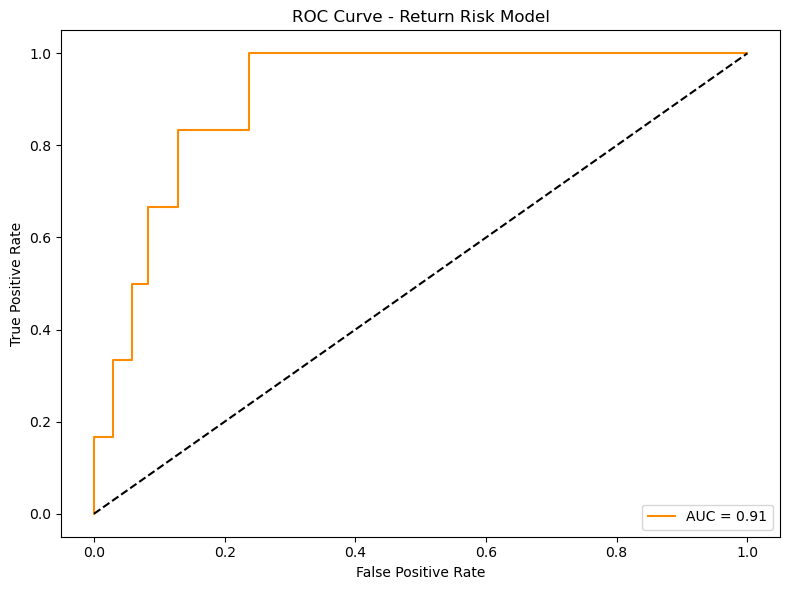

In [27]:
# ROC Curve plot
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Return Risk Model")
plt.legend(loc='lower right')
plt.tight_layout()

plt.savefig("../visuals/charts/roc_curve.png")
plt.show()

#### Save Model Metrics to File

In [28]:
# Save key performance scores to CSV
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_proba)
}

metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Score'])
metrics_df.to_csv("../cleaned/model_performance_metrics.csv")
metrics_df

,Score
Accuracy,0.858300
Precision,0.128205
Recall,0.833333
F1 Score,0.222222
AUC,0.910788


#### Feature Importance from Logistic Regression

In [29]:
# Match feature names with coefficients
coefficients = pd.DataFrame({
    'Feature': features,
    'Importance': model.coef_[0]
}).sort_values(by='Importance', key=abs, ascending=False)

# Display top features
coefficients

,Feature,Importance
8,low_rating,3.351891
4,is_late,1.423470
6,sentiment_score,-0.768387
2,order_value,0.595999
1,quantity,-0.573226
5,customer_rating,0.469660
3,delivery_delay,0.455871
0,price,-0.166865
7,has_complaint,0.000000


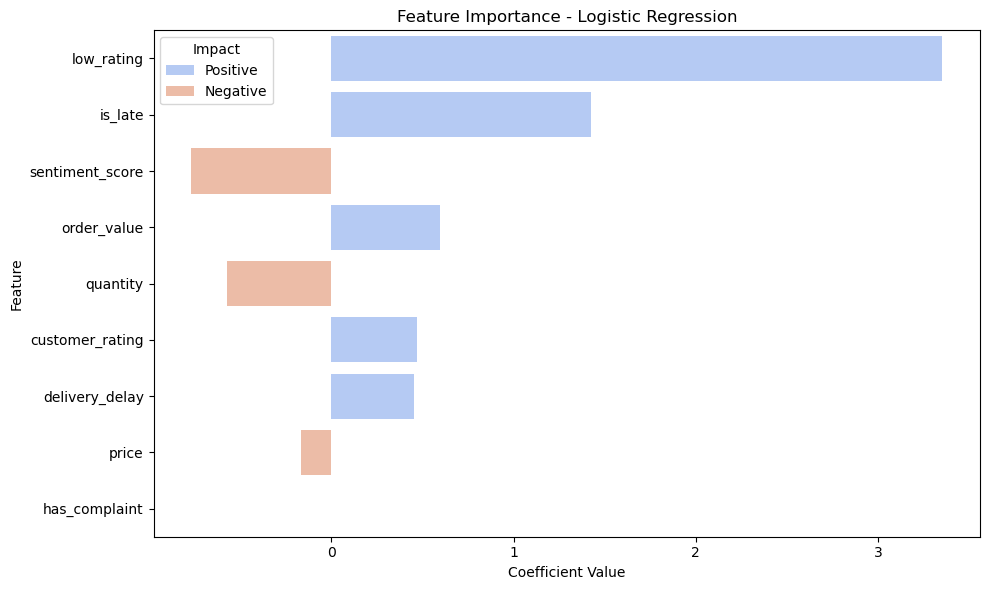

In [30]:
#group feature impact
coefficients['impact'] = coefficients['Importance'].apply(lambda x: 'Positive' if x > 0 else 'Negative')

# Plot Feature Importance
plt.figure(figsize=(10,6))
sns.barplot(
    data=coefficients, 
    x='Importance',
    y='Feature',
    hue='impact',
    palette='coolwarm',
    dodge=False
)
plt.title("Feature Importance - Logistic Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.legend(title="Impact")
plt.tight_layout()

plt.savefig("../visuals/charts/feature_importance_logreg.png")
plt.show()

In [31]:
# Save model and scaler
joblib.dump(model, "../models/return_model.pkl")
joblib.dump(scaler, "../models/return_scaler.pkl")

['../models/return_scaler.pkl']

## Phase 3 Summary: Modeling Return Risk

In this phase, I built a classification model to predict the likelihood of a customer returning an item. This helps AfriMarket proactively reduce logistics costs, spot high-risk orders, and intervene early.

### Modeling Approach
- **Model Used**: Logistic Regression (with `class_weight='balanced'`)
- **Dataset Size**: 987 orders
- **Target Class Imbalance**: Only ~2.4% of orders were returns
- **Train-Test Split**: 75/25 stratified split (to preserve return balance)
- **Features Used**: Price, Quantity, Order Value, Delivery Delay, Ratings, Sentiment, etc.

### Key Results
| Metric        | Score     |
|---------------|-----------|
| **Accuracy**  | 86%       |
| **Precision (Returns)**| 13%   |
| **Recall (Returns)**   | 83%   |
| **F1 Score (Returns)** | 22%   |
| **AUC-ROC**     **0.91**  |

> High **recall** and **AUC** make the model suitable for flagging risky orders, even at the cost of more false positives — a worthwhile trade-off for a return-prevention use case.

---

### Top Predictive Features
| Feature          | Impact     |
|------------------|------------|
| `low_rating`     | Strongest return predictor (coeff = 3.35)  
| `is_late`        | Late deliveries increase return risk  
| `sentiment_score`| Negative reviews correlate with returns  
| `order_value`    | Higher value orders slightly more likely to be returned  

> These insights help explain not just *which* orders are risky, but *why* — empowering the business to act.

> Coefficient signs indicate direction: positive means higher return likelihood, negative means lower.

> *Note: Model coefficients were derived from a standardized logistic regression model using `StandardScaler()` preprocessing.*


---

This model lays the foundation for targeted return prevention strategies, which will be developed in **Phase 4**.
